In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import os
import pickle
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



# Finding Lane Lines

*** Steps ***

    i)  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    ii) Apply a distortion correction to raw images.
    iii)Use color transforms, gradients, etc., to create a thresholded binary image.
    iv) Apply a perspective transform to rectify binary image ("birds-eye view").
    v) Detect lane pixels and fit to find the lane boundary.
    vi)Determine the curvature of the lane and vehicle position with respect to center.
    vii)Warp the detected lane boundaries back onto the original image.
    ix)Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position


## The following functions are defined to be used for finding lane lines etc

In [2]:
# As step 1 , first Load camera matrix and distortion coefficients which are pre-calculated in undistort_camera.ipynb
dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
camera_img_size = dist_pickle['imagesize']

In [3]:
# As step 2, distort correction , takes raw image and returns undistorted image
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    assert (img_size1 == camera_img_size),'image size not compatible'
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
# Used to smoothen the images by filtering out noises
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Gradient thresholds

In [5]:
# Sobel filters detect edges.Taking the gradient in the x-direction emphasizes edges closer to vertical and in the y-direction,
# edges closer to horizontal. Setting the thresholds is to identify pixels within a certain gradient range

# Define a function that takes an image, gradient orientation, and threshold min / max values and returns binary image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [6]:
# It picks up the lane lines well, but with a lot of other stuff detected too. Gradient magnitude is at the heart of 
# Canny edge detection, and is why Canny works well for picking up all edges 

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
#In the case of lane lines, we're interested only in edges of a particular orientation, ie.,orientation of the gradient.

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Color thresholds

In [8]:
# In HLS color space, the S channel does fairly robust job of picking up the lines under very different color and contrast 
# conditions (particularly yellow lines of lane)
# In RGB color space, the R channel does better in picking up white lines but drawback is any light (near white)
# road part also detects
# In HSV space, the white lane lines are picked(not enough )


In [9]:
# Threshold color channel
def color_threshold(img,s_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    #img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #white_hsv_low  = np.array([  20,   0,   200])
    #white_hsv_high = np.array([ 255,  80, 255])
    #white_binary = ((cv2.inRange(img_hsv, white_hsv_low, white_hsv_high))/255).astype(int)
    
    r_channel = img[:,:,0]
    thresh = (200, 255)
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
        
    return s_binary,r_binary

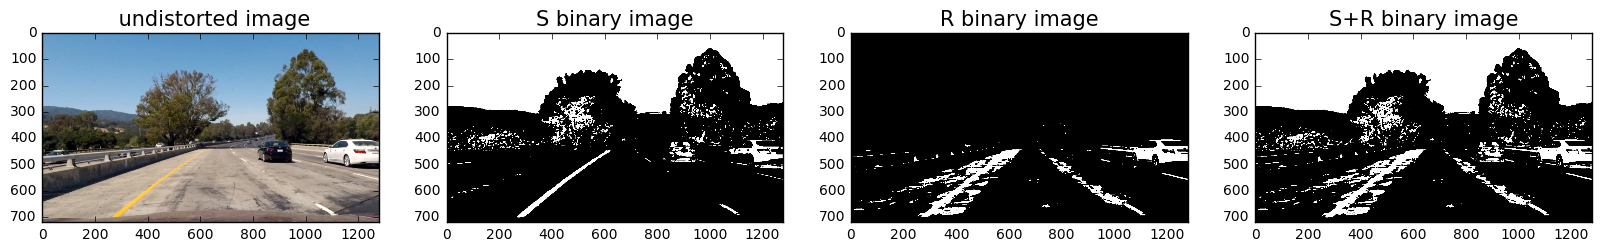

In [10]:
image = mpimage.imread('test_images/test1.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)

kernel_size = 3
image = gaussian_blur(image, kernel_size)
s_binary,r_binary = color_threshold(image,(100,255))

# Combine the two binary thresholds
combined_binary = np.zeros_like(s_binary)
combined_binary[(s_binary == 1) | (r_binary == 1)] = 1

### Visualization
f, (ax1, ax2 , ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(image)
ax1.set_title(' undistorted image', fontsize=15)
ax2.imshow(s_binary,cmap='gray')
ax2.set_title('S binary image', fontsize=15)
ax3.imshow(r_binary,cmap='gray')
ax3.set_title('R binary image', fontsize=15)
ax4.imshow(combined_binary,cmap='gray')
ax4.set_title('S+R binary image', fontsize=15)


# Color and Gradient
*** Now it's time to combine what you know about color and gradient thresholding to get the best of both worlds.***

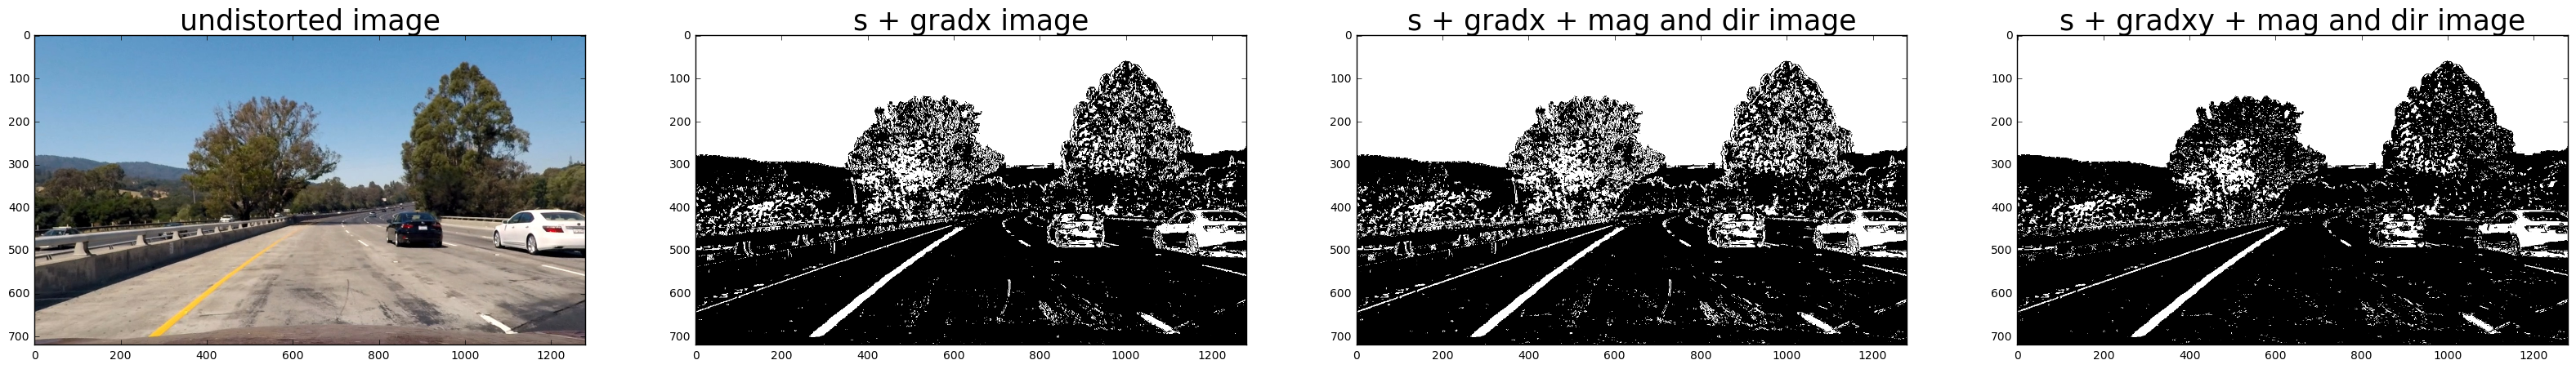

In [11]:
image = mpimage.imread('test_images/test1.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)

ksize = 3
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(100, 150))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
s_binary,r_binary = color_threshold(image,(100,255))

combined_binary = np.zeros_like(gradx)
combined_binary1 = np.zeros_like(gradx)
combined_binary2 = np.zeros_like(gradx)

combined_binary[(s_binary == 1) | (gradx == 1)] = 1

combined_binary1[(s_binary == 1) | (gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) ] = 1

combined_binary2[(s_binary == 1) | ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

### Visualization
f, (ax1, ax2 ,ax3 ,ax4) = plt.subplots(1,4, figsize=(40,20))
ax1.imshow(image)
ax1.set_title('undistorted image', fontsize=25)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('s + gradx image', fontsize=25)
ax3.imshow(combined_binary1,cmap='gray')
ax3.set_title('s + gradx + mag and dir image', fontsize=25)
ax4.imshow(combined_binary2,cmap='gray')
ax4.set_title('s + gradxy + mag and dir image', fontsize=25)


# Transform Perspective

In [12]:
### Perspective transform is one time calculation
def perspective_transform():
    src = np.float32([[616,465],[656,465],[1120,720],[205,720]])  # best working
    dst = np.float32([[430,0],[656,0],[955,720],[205,720]])  # best working
            
    #use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M,Minv
        

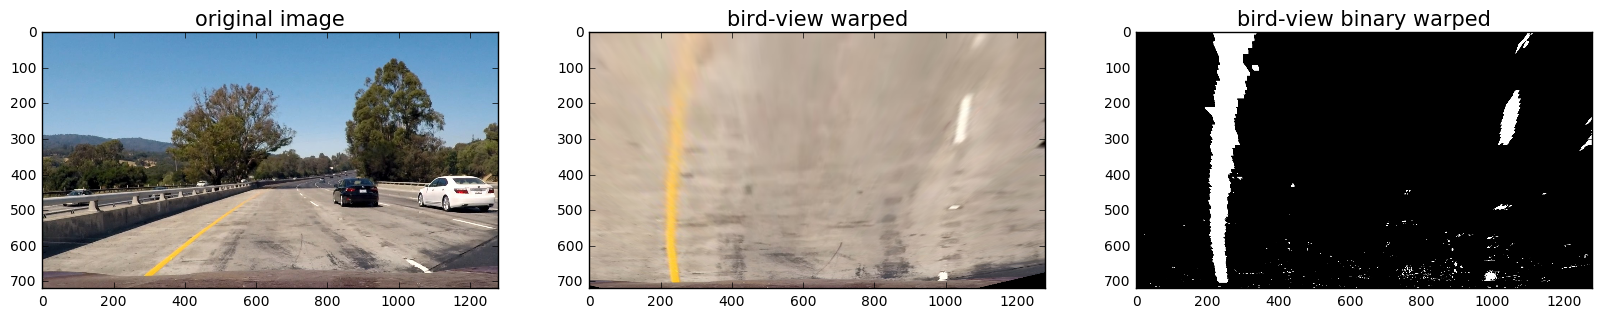

In [13]:
def corners_unwarp(image):
    ### Visualization of images as bird-view
    
    ksize = 3
    
    img_size = (image.shape[1],image.shape[0])

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(100, 150))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    s_binary,r_binary = color_threshold(image,(100,255))
    
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (gradx ==1) | ((mag_binary == 1) & (dir_binary == 1)) ] = 1
    
    warped =  cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped,binary_warped

M,Minv = perspective_transform()
image = mpimage.imread('test_images/test1.jpg')
warped,binary_warped = corners_unwarp(image)
                           
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('original image', fontsize=15)
ax2.imshow(warped)
ax2.set_title('bird-view warped', fontsize=15)
ax3.imshow(binary_warped,cmap='gray')
ax3.set_title('bird-view binary warped', fontsize=15)

In [14]:
def get_val(y,poly_coeff):
    # Returns value of a quadratic polynomial 
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

(720, 0)

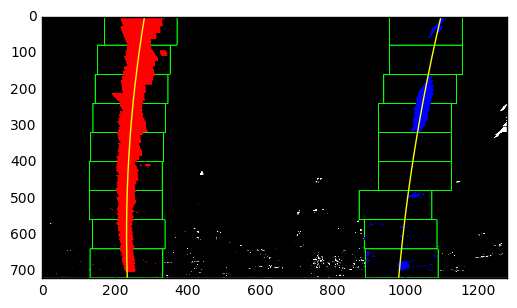

In [15]:
def polynomial_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
       
    return left_fit,right_fit,leftx,lefty,rightx,righty


### Visualization of windowing and polynomial fit

image = mpimage.imread('test_images/test1.jpg')
warped,binary_warped = corners_unwarp(image)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
left_fit,right_fit,leftx,lefty,rightx,righty = polynomial_fit(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = get_val(ploty,left_fit)
right_fitx = get_val(ploty,right_fit)

out_img[lefty, leftx] = [255, 0, 0]  # Red 
out_img[righty, rightx] = [0, 0, 255] # Blue

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

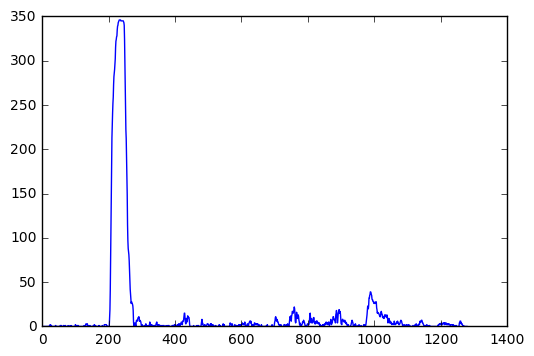

In [16]:


histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)



In [17]:
def skip_sliding_windows(binary_warped,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
      
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
       
    return left_fit,right_fit,leftx,lefty,rightx,righty

(720, 0)

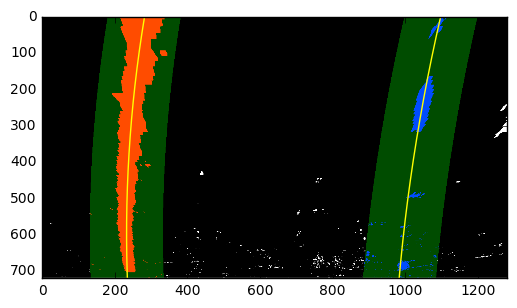

In [18]:

left_fit,right_fit,leftx,lefty,rightx,righty = skip_sliding_windows(binary_warped,left_fit,right_fit)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
margin = 100
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]  # Red 
out_img[righty, rightx] = [0, 0, 255] # Blue

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = get_val(ploty,left_fit)
right_fitx = get_val(ploty,right_fit)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
def draw_lanelines(binary_warped,undist,left_fit,right_fit):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    bird_view,binary_warped = corners_unwarp(result)
        
    return result,bird_view

In [20]:
def measure_curve(left_fit,right_fit):
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
      
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
       
    leftx = left_fitx
    rightx = right_fitx

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curve_rad = np.round((left_curverad + right_curverad)/2,2)
    return curve_rad

In [21]:
def lane_offset(img,left_fit,right_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    image_center = img.shape[1]/2
    ## Compute intercepts
    left_bot = get_val(img.shape[0],left_fit)
    right_bot = get_val(img.shape[0],right_fit)
    
    ## Compute center location
    lane_center = (left_bot+right_bot)/2.0
    
    distance = image_center - lane_center
    
    return (distance*xm_per_pix)

In [22]:
def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

In [23]:
def process_image(img):
    
    global first_frame
    global left_fit_prev
    global right_fit_prev
    img_size = (img.shape[1], img.shape[0])
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y

    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist = distort_correct(img,mtx,dist,camera_img_size)
        
    bird_view, binary_warped = corners_unwarp(undist)
    
    if first_frame == 1:
        #left_fit,right_fit,ploty,left_fitx,right_fitx = polynomial_fit(binary_warped)
        left_fit,right_fit,leftx,lefty,rightx,righty = polynomial_fit(binary_warped)
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        first_frame = 0
    else:
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        left_fit,right_fit,leftx,lefty,rightx,righty = skip_sliding_windows(binary_warped,left_fit,right_fit)
        #left_fitx, right_fitx,ploty,left_fit,right_fit = skip_sliding_windows(binary_warped,left_fit,right_fit)
    
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
    else:
        right_fit = 0.15*right_fit + 0.85*right_fit_prev
    
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit = left_fit_prev
        
    else:
        left_fit = 0.15*left_fit + 0.85*left_fit_prev
        
    
    left_fit_prev = left_fit
    right_fit_prev = right_fit
                
    result,bird_view  = draw_lanelines(binary_warped,undist,left_fit,right_fit)
        
    curve_rad = measure_curve(left_fit,right_fit)
    
    distance = np.round((lane_offset(img,left_fit,right_fit)*100),2)
    font = cv2.FONT_HERSHEY_COMPLEX 
    result = cv2.putText(result, 'radius of curvature : '+str(curve_rad)+' m', (30, 40), font, 1, (0,255,0), 2)
    result = cv2.putText(result, 'offset from lane center : '+str(distance)+' cm', (30, 80), font, 1, (0,255,0), 2)
    
    
    if diag == 1:
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(bird_view, (320,240), interpolation=cv2.INTER_AREA) 
        return diagScreen
    else:
        return result
    


In [24]:
#List all filenames from dir test_images
filenames = os.listdir("test_images/")
global first_frame
diag = 1
for filename in filenames:
    first_frame = 1
    image = mpimage.imread('test_images/'+filename)
    
    lane_image = process_image(image)
    mpimage.imsave('output_images/lane_'+filename,lane_image)

In [25]:
diag = 1
global first_frame 
first_frame = 1

project_video_output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')

project_video_clip = clip2.fl_image(process_image)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:46<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 15min 49s


In [ ]:
diag = 0
global first_frame 
first_frame = 1
challenge_video_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')

challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))